In [1]:
import multiprocessing
multiprocessing.set_start_method('spawn')
multiprocessing.cpu_count()

4

In [2]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [3]:
from torch.utils.tensorboard import SummaryWriter
tb_writer = SummaryWriter("runs/malayalam handwriting classification model - 3")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Visualization and Pre - processing

In [5]:
# Load the image
image_path = 'data/അ/3.png'
image = Image.open(image_path)

In [6]:
# Convert the image to a NumPy array
image_array = np.array(image)

# Find the max and min pixel values
max_pixel_value = np.max(image_array)
min_pixel_value = np.min(image_array)
mean_pixel_value = np.mean(image_array)

print(f'Max pixel value: {max_pixel_value}')
print(f'Min pixel value: {min_pixel_value}')
print(f'Mean pixel value: {mean_pixel_value}')

Max pixel value: 255
Min pixel value: 0
Mean pixel value: 4.641019444444445


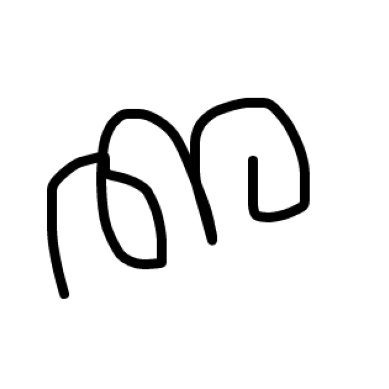

In [7]:
# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

### testing transform on 1 image

In [8]:
raw_transform = transforms.Compose([
    transforms.Resize((32, 32)),                    # Resize to 32x32 pixels
    transforms.ToTensor(),                          # Convert to PyTorch tensor
])

In [9]:
transformed_image = raw_transform(image)

In [10]:
# find max, mean and min pixel values
print("Tensor shape:", transformed_image.shape)
print("Min pixel value:", transformed_image.min().item())
print("Max pixel value:", transformed_image.max().item())
print("Mean pixel value:", transformed_image.mean().item())

Tensor shape: torch.Size([4, 32, 32])
Min pixel value: 0.0
Max pixel value: 0.886274516582489
Mean pixel value: 0.01819661632180214


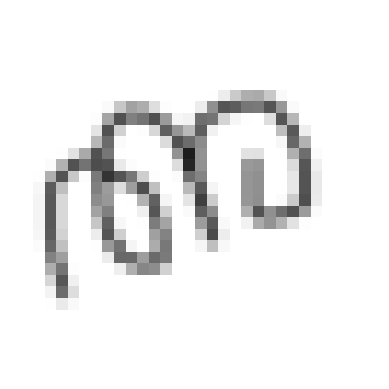

In [11]:
plt.imshow(transformed_image.permute(1, 2, 0).numpy().clip(0,1))
plt.axis("off")
plt.show()

### Checking the datsaset

In [13]:
# Path to a sample image
sample_img_path = "data\അ\\3.png"

# Open the image
img = Image.open(sample_img_path)
print(f"Image mode: {img.mode}")  # Should be "RGB" or "RGBA
print(f"Image size: {img.size}")

# Convert to NumPy array and inspect pixel values
img_array = np.array(img)
print(f"Pixel range: {img_array.min()} to {img_array.max()}")


Image mode: RGBA
Image size: (300, 300)
Pixel range: 0 to 255


In [14]:
# Load a single image from your dataset
image_path = "data\ഛ\\2.png"  # Adjust this path based on your dataset
image = Image.open(image_path)

# Convert the image to a numpy array
image_np = np.array(image)

# Display the pixel values of the image
print(f"Min pixel value: {image_np.min()}")
print(f"Max pixel value: {image_np.max()}")
print(f"Mean pixel value: {image_np.mean()}")


Min pixel value: 0
Max pixel value: 255
Mean pixel value: 5.382888888888889


### Creating a dictionary with image path as key and class as value

In [15]:
data_dir = 'data'  # Path to the root data directory containing subfolders
letter_dict = {"rgb_data/"+folder: idx for idx, folder in enumerate(os.listdir(data_dir))}
print(letter_dict)

{'rgb_data/അ': 0, 'rgb_data/ആ': 1, 'rgb_data/ഇ': 2, 'rgb_data/ഉ': 3, 'rgb_data/എ': 4, 'rgb_data/ഏ': 5, 'rgb_data/ഒ': 6, 'rgb_data/ക': 7, 'rgb_data/ഖ': 8, 'rgb_data/ഗ': 9, 'rgb_data/ഘ': 10, 'rgb_data/ങ': 11, 'rgb_data/ച': 12, 'rgb_data/ഛ': 13, 'rgb_data/ജ': 14, 'rgb_data/ഝ': 15, 'rgb_data/ഞ': 16, 'rgb_data/ട': 17, 'rgb_data/ഠ': 18, 'rgb_data/ഡ': 19, 'rgb_data/ഢ': 20, 'rgb_data/ണ': 21, 'rgb_data/ത': 22, 'rgb_data/ഥ': 23, 'rgb_data/ദ': 24, 'rgb_data/ധ': 25, 'rgb_data/ന': 26, 'rgb_data/പ': 27, 'rgb_data/ഫ': 28, 'rgb_data/ബ': 29, 'rgb_data/ഭ': 30, 'rgb_data/മ': 31, 'rgb_data/യ': 32, 'rgb_data/ര': 33, 'rgb_data/റ': 34, 'rgb_data/ല': 35, 'rgb_data/ള': 36, 'rgb_data/ഴ': 37, 'rgb_data/വ': 38, 'rgb_data/ശ': 39, 'rgb_data/ഷ': 40, 'rgb_data/സ': 41, 'rgb_data/ഹ': 42}


### Creating the Custom dataset loader

In [16]:
class MalHandwritingDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, label)

### Converting RGBA images to RGB images

In [17]:
from conversion import convert_rgba_to_rgb

# Paths
input_dir = "data"      # Original folder containing the class folders
output_dir = "rgb_data"    # New folder to store the converted images

# Create the output directory structure
for root, dirs, files in os.walk(input_dir):
    # Create corresponding directories in the output path
    relative_path = os.path.relpath(root, input_dir)
    target_path = os.path.join(output_dir, relative_path)
    os.makedirs(target_path, exist_ok=True)
    
    for file_name in files:
        input_path = os.path.join(root, file_name)
        output_path = os.path.join(target_path, file_name)
        
        # Convert images to RGB
        try:
            convert_rgba_to_rgb(input_path, output_path)
            print(f"Converted: {input_path} -> {output_path}")
        except Exception as e:
            print(f"Error processing {input_path}: {e}")


Converted: data\അ\100.png -> rgb_data\അ\100.png
Converted: data\അ\101.png -> rgb_data\അ\101.png
Converted: data\അ\102.png -> rgb_data\അ\102.png
Converted: data\അ\103.png -> rgb_data\അ\103.png
Converted: data\അ\104.png -> rgb_data\അ\104.png
Converted: data\അ\105.png -> rgb_data\അ\105.png
Converted: data\അ\106.png -> rgb_data\അ\106.png
Converted: data\അ\107.png -> rgb_data\അ\107.png
Converted: data\അ\108.png -> rgb_data\അ\108.png
Converted: data\അ\109.png -> rgb_data\അ\109.png
Converted: data\അ\11.png -> rgb_data\അ\11.png
Converted: data\അ\110.png -> rgb_data\അ\110.png
Converted: data\അ\111.png -> rgb_data\അ\111.png
Converted: data\അ\112.png -> rgb_data\അ\112.png
Converted: data\അ\113.png -> rgb_data\അ\113.png
Converted: data\അ\114.png -> rgb_data\അ\114.png
Converted: data\അ\115.png -> rgb_data\അ\115.png
Converted: data\അ\116.png -> rgb_data\അ\116.png
Converted: data\അ\117.png -> rgb_data\അ\117.png
Converted: data\അ\118.png -> rgb_data\അ\118.png
Converted: data\അ\119.png -> rgb_data\അ\11

#### Creating labels.csv for newly converted files
- This is a csv file with all image paths and class labels stored next to each other, created from letter_dict dictionary

In [18]:
# creating data path
root_dir = "rgb_data"

# Dictionary to store image names and labels
image_label_dict = {}

# Iterate through all subdirectories and files
for label_name in os.listdir(root_dir):
    label_path = os.path.join(root_dir, label_name)
    
    # Ensure it's a directory
    if os.path.isdir(label_path):
        for file_name in os.listdir(label_path):
            # Check if the file is an image (optional: add more extensions if needed)
            if file_name.endswith('.png'):
                image_label_dict[label_name+"/"+file_name] = letter_dict["rgb_data"+"/"+label_name]

# Print the dictionary
for image, label in list(image_label_dict.items())[:10]:  # Display the first 10 entries
    print(f"Image: {image}, Label: {label}")

# Total number of entries
print(f"\nTotal images: {len(image_label_dict)}")


Image: അ/100.png, Label: 0
Image: അ/101.png, Label: 0
Image: അ/102.png, Label: 0
Image: അ/103.png, Label: 0
Image: അ/104.png, Label: 0
Image: അ/105.png, Label: 0
Image: അ/106.png, Label: 0
Image: അ/107.png, Label: 0
Image: അ/108.png, Label: 0
Image: അ/109.png, Label: 0

Total images: 5566


In [19]:
import csv

# Path to save the CSV file
csv_file_path = "labels.csv"

# Write the dictionary to a CSV file
with open(csv_file_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Image Name", "Class Label"])  # Header row
    for image_name, class_label in image_label_dict.items():
        writer.writerow([image_name, class_label])

print(f"CSV file saved at: {csv_file_path}")


CSV file saved at: labels.csv


### The final transforms
#### Loading the dataset and applying transforms

In [27]:
def load_data(data_augmentation=False):
    
    transform_original = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
    
    transform_augmented = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(
        brightness=0.5,  # Randomly change brightness
        contrast=0.5,   # Randomly change contrast
        saturation=0.5, # Randomly change saturation
        hue=0.1         # Randomly change hue
    ),
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
    
    if data_augmentation:
        original_dataset = MalHandwritingDataset(
                                csv_file="labels.csv",
                                root_dir=root_dir,
                                transform=transform_original)
        
        augmented_dataset = MalHandwritingDataset(
                                csv_file="labels.csv",
                                root_dir=root_dir,
                                transform=transform_augmented)
        
        dataset = torch.utils.data.ConcatDataset([original_dataset, augmented_dataset])
    else:
        dataset = MalHandwritingDataset(
                            csv_file="labels.csv",
                            root_dir=root_dir,
                            transform=transform_original)
        
    # Split dataset into training and testing
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader

    

In [28]:
root_dir = "rgb_data"

In [29]:
train_loader, test_loader = load_data(data_augmentation=True)

In [30]:
# Check the first batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch size: {images.shape}")  # e.g., torch.Size([32, 3, 64, 64])
print(f"Labels: {labels}")
print(len(labels))


Batch size: torch.Size([32, 3, 32, 32])
Labels: tensor([ 9, 20,  3, 11,  5,  3, 38, 39,  2, 29, 17, 14, 38, 26, 28,  5, 27, 10,
        35, 23, 21, 22, 41, 22, 39, 22, 38, 11, 38, 36, 25, 23])
32


#### displaying pixel values

In [31]:
# Check the min and max pixel values
print(f'Min pixel value: {images[0][0].min().item()}')
print(f'Max pixel value: {images[0][0].max().item()}')
print(f"Mean Pixel Value: {images[0][0].mean().item()}")

Min pixel value: 0.3137255012989044
Max pixel value: 1.0
Mean Pixel Value: 0.966015636920929


#### Visualizing one batch of images

(-0.5, 273.5, 137.5, -0.5)

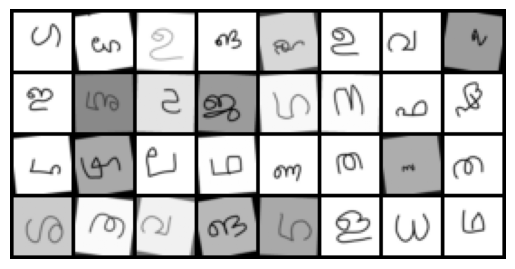

In [32]:
# Create a grid of images
img_grid = torchvision.utils.make_grid(images, nrow=8)  # 8 images per row

# Convert the grid to a NumPy array and transpose the dimensions
np_grid = img_grid.numpy().clip(0,1)

np_grid = np_grid.transpose((1, 2, 0))

# Display the grid of images
plt.imshow(np_grid)
plt.axis('off')  # Hide the axis
# Add the grid of images to TensorBoard
# tb_writer.add_image("MalHandwriting", img_grid)
# # Close the writer
# tb_writer.close()


In [33]:
print(images.shape)

torch.Size([32, 3, 32, 32])


In [34]:
num_classes = len(os.listdir("rgb_data"))
print(num_classes)

43


## Model Architecture

In [35]:
# Hyper-parameters
num_epochs = 500
batch_size = 32
# 6000 images in dataset, 80% for training -> 4800 images so 4800/32 = 150 iterations per epoch
learning_rate = 0.0001

In [36]:
# implement the CNN

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.AvgPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.AvgPool2d(2, 2)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 16 * 5 * 5 is the size of the input to the fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        
        # first conv2d layer
        x = self.pool(F.relu(self.conv1(x)))

        # second conv2d layer
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten the tensor
        x = x.view(-1, 16 * 5 * 5)
        
        
        # first fully connected layer
        x = F.relu(self.fc1(x))
        
        
        # second fully connected layer  
        x = F.relu(self.fc2(x))
        
        
        # third fully connected layer
        x = self.fc3(x)
        # last is softmax layer but that is done by optimizer
        
        return x
        

In [37]:
model = ConvNet()
# Move the model to the GPU
model = model.to(device)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
tb_writer.add_graph(model, images)
tb_writer.close()

In [ ]:
n_total_steps = len(train_loader)
best_loss = np.inf

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [32,3,64,64] = 32,3,1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        
        images = images.to(device)
        labels = labels.to(device)
        
        
        # forward pass
        output = model(images)
        loss = criterion(output, labels)
        
        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()
        
        # # Calculate accuracy
        # _, predicted = torch.max(output.data, 1)
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()
        
        # Log the loss to TensorBoard
        tb_writer.add_scalar('Training Loss', loss.item(), epoch * n_total_steps + i)
    
        if i == n_total_steps//2:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item()}')
            # Save the model if the current val_loss is the lowest
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), 'mal_model.pth')
        
    # Calculate and log average loss and accuracy for the epoch
    epoch_loss = running_loss / n_total_steps
    #epoch_accuracy = 100 * correct / total
    tb_writer.add_scalar('Epoch Loss', epoch_loss, epoch)
    #tb_writer.add_scalar('Epoch Accuracy', epoch_accuracy, epoch)
            
print('Finished Training')
tb_writer.close()

In [38]:
classes = [i for i in os.listdir("rgb_data")]
print(classes)

['അ', 'ആ', 'ഇ', 'ഉ', 'എ', 'ഏ', 'ഒ', 'ക', 'ഖ', 'ഗ', 'ഘ', 'ങ', 'ച', 'ഛ', 'ജ', 'ഝ', 'ഞ', 'ട', 'ഠ', 'ഡ', 'ഢ', 'ണ', 'ത', 'ഥ', 'ദ', 'ധ', 'ന', 'പ', 'ഫ', 'ബ', 'ഭ', 'മ', 'യ', 'ര', 'റ', 'ല', 'ള', 'ഴ', 'വ', 'ശ', 'ഷ', 'സ', 'ഹ']


In [ ]:
with torch.no_grad():
    n_samples = 0
    n_correct = 0
    n_class_correct = [0 for i in range(48)]  # 48 classes
    n_class_samples = [0 for i in range(48)]  # 48 classes

    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc:.2f} %')
    tb_writer.add_scalar('Accuracy/Overall', acc)

    for i in range(48):  # Iterate over the range of the number of classes
        if n_class_samples[i] > 0:
            class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {class_acc:.2f} %')
            tb_writer.add_scalar(f'Accuracy/{classes[i]}', class_acc)
        else:
            print(f'Accuracy of {classes[i]}: N/A (no samples)')

tb_writer.close()

### Testing one one new prediction

In [42]:
import pandas as pd
df =pd.read_csv("labels.csv")
df.rename(columns={'Image Name': 'image', 'Class Label': 'label'}, inplace=True)
df.head()

,image,label
0,അ/100.png,0
1,അ/101.png,0
2,അ/102.png,0
3,അ/103.png,0
4,അ/104.png,0


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

unique_value = 'character_3333/3.png'

# Print the row where 'image' column has the unique value
row = df.loc[df['image'] == unique_value]
print(row)

# Load and transform the image
image = Image.open('rgb_data/character_3333/3.png')
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")

In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

unique_value = 'character_3375/3.png'

# Print the row where 'image' column has the unique value
row = df.loc[df['image'] == unique_value]
print(row)

# Load and transform the image
image = Image.open('rgb_data/character_3375/3.png')
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")

In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

unique_value = 'character_3374/8.png'

# Print the row where 'image' column has the unique value
row = df.loc[df['image'] == unique_value]
print(row)

# Load and transform the image
image = Image.open('rgb_data/character_3374/8.png')
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")

### Testing on a new example that was drawn on paint

In [ ]:
# Load the image
image_path = 'diya_maaaaaaaaaaaa.png'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
transformed_image = raw_transform(image)
# displaying the transformed image
plt.imshow(transformed_image.permute(1, 2, 0).numpy().clip(0,1))
plt.axis("off")
plt.show()

In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode


# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")

In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "diya_ingaaaaaaaaaaaaaaaaa.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "bhaaaaaaaaaaaaaaa.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "diya_nnnnnnnnnnnnnn.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "diya_paaaaaaaaaaaaaaaaaaaaaaaaaaaaaa.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "diya_vaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]


In [ ]:
# Load the state dictionary
model.load_state_dict(torch.load('mal_model.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

image_path = "raaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa.png"

# Load and transform the image
image = Image.open(image_path)
transformed_image = raw_transform(image)
transformed_image = transformed_image.unsqueeze(0)  # Add a batch dimension

# Pass the input through the model
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted class: {predicted.item()}")
df[df['label'] == predicted.item()]
